In [14]:
import torch
import numpy as np
from matplotlib import pyplot
import math

# Introducción a redes neuronales en pytorch

En este notebook veremos como aprovechar la diferenciación automática que provee Pytorch (autograd) para programar redes neuronales.

Lo haremos para identificar dígitos (número del 0-9) dada una imagen del mismo. 

El dataset es conocido como MNIST. La idea NO es aprender a reconocer dígitos (ni imágenes) sino fijar los conceptos de redes neuronales y ver como se implementan en Pytorch. Además conocer práctica habituales a la hora de entrenar redes neuronales

### Descargando el dataset

Descargaremos el dataset MNIST de la página de pytorch. Para ello crearemos un subdirectorio en nuestra carpeta actual llamado "data" donde guardaremos nuestros datasets (esta es una práctica habitual en los proyectos de Machine Learning). Dentro de la carpeta "data" crearemos una subcarpeta para cada dataset. En este caso crearemos la subcarpeta "mnist":

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

# Creara ./data/mnist si no existe 
# (si no existe ./data lo creará y creará ./data/mnist)
# (y si existe pero no existe ./data/mnist sólo creará este último).
# Cualquier cuestión que no se entienda, consultar la documentación de las librerías
# por ejemplo https://docs.python.org/3/library/pathlib.html
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

# Descargamos mnist.pkl.gz utilizando un HTTP GET request
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

### Cargando el dataset

Cada dataset tiene diferentes formas. Hay veces que se presenta como un conjunto de imágenes dentro de carpetas cuyo nombre indica la clase a la que pertenece. En este caso el dataset MNIST descargado contiene 4 numpy arrays con los datos de las imágenes y las clases de train y tests respectivamente

In [6]:
import pickle
import gzip

# Los arrays de las imagenes fueron guardados en un archivo formato pickle, que se utiliza para persistir variable en Python
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [5]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

#### Visualizando el dataset

Visualizemos la clase y la imagen del primer elemento del training set:

In [7]:
y_train[0]

5

x_train contiene el valor de los $28 \times 28$ pixeles "aplanado" (transformado en una sóla dimensión de longitud 784)

In [12]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Para visualizar la imagen tenemos que volver al array de pixeles a su estado original (dos dimensiones de tamaño 28)

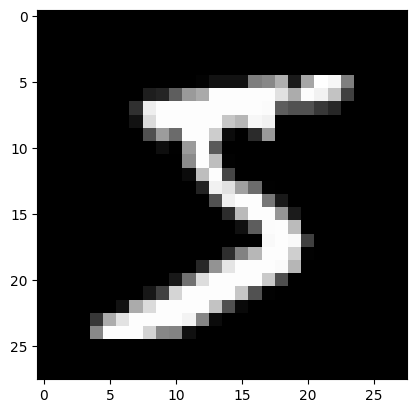

In [10]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()

## Creando nuestra red neuronal

Vimos que una red neuronal es una composición de funciones que llevan de $\large \mathbb{R}^{n_{in}}$ a $\large \mathbb{R}^{n_{out}}$, como composición de funciones que transforman vectores en vectores:

$\Large \mathbb{R}^{n_{in}} \rightarrow \mathbb{R}^{n_{hidden_1}} \rightarrow \mathbb{R}^{n_{hidden_2}} \rightarrow ... \rightarrow \mathbb{R}^{n_{out}}$

Vamos a entrenar una red de dos capas ocultas de tamaño 512. O sea concretamente nuestra red tendrá la forma:

$\Large \mathbb{R}^{784} \rightarrow \mathbb{R}^{512} \rightarrow \mathbb{R}^{512} \rightarrow \mathbb{R}^{10}$

Como vimos cada función toma los valores de la capa anterior $h_{t}$ y produce los de la capa subsiguiente $h_{t+1}$ aplicando una transformación lineal seguida de una función no-lineal $g$:

$h_{t+1} = g( h_t \times W_t + b_t )$

$g$ será la función $ReLU$ excepto para la última capa que utilizaremos la función softmax:

$ReLU(x) = max(0, x)$

La función softmax toma un vector de longitud $n$, lo positiviza aplicando $e^x$ y luego divide cada componente por la suma de cada uno de dichos términos positivos. Como resultado da un vector de longitud $n$ que es siempre positivo y la suma es $1$. Se utiliza cuando se espera que la salida sea una distribución de probabilidad. En problemas de clasificación, la salida son $n$ probabilidades siendo $n$ el número de clases (la probabilidad que da el modelo para que el $x$ suministrado pertenezca a cada una de las clases).

Los pesos de cada capa son inicializados de manera aleatoria con una fórmula que los escala teniendo en cuenta la dimensión de entrada y salida. Lo que se pretende con esto es que los valores de las activaciones no crezcan demasiado, ya que de hacerlo luego e^x (aplicado en la última capa por la softmax resultará en el valor inf.

In [80]:
def w_rand(n_in, n_out):
    return torch.normal(0, math.sqrt(6) / math.sqrt(n_in + n_out), size=(n_in,n_out), requires_grad=True)

W_1 = w_rand(28*28, 512)
b_1 = torch.zeros(512, requires_grad=True)

W_2 = w_rand(512, 512)
b_2 = torch.zeros(512, requires_grad=True)

W_3 = w_rand(512,10)
b_3 = torch.zeros(10, requires_grad=True)

weights = [W_1, b_1, W_2, b_2, W_2, b_3]

def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def calculate_predictions(t):
    linear_combination_1 = t @ W_1 + b_1
    hidden_layer_1 = torch.max(torch.tensor(0), linear_combination_1)
    
    linear_combination_2 = hidden_layer_1 @ W_2 + b_2
    hidden_layer_2 = torch.max(torch.tensor(0), linear_combination_2)

    linear_combination_3 = hidden_layer_2 @ W_3 + b_3
    
    return softmax(linear_combination_3)

pred = calculate_predictions(torch.tensor(x_train[0]))
pred, pred.shape

(tensor([0.0268, 0.0524, 0.0326, 0.0822, 0.0066, 0.0279, 0.6542, 0.0038, 0.1013,
         0.0121], grad_fn=<DivBackward0>),
 torch.Size([10]))

Podemos corroborar que efectivamente la salida suma 1 (como debe ser por ser una distribución de probabilidad):

In [29]:
pred.sum()

tensor(1., grad_fn=<SumBackward0>)

Necesitamos una función que nos genere los mini-batches, no queremos evaluar los 50000 arrays en cada iteración de descenso por gradiente:

In [27]:
batch_size = 32

def get_batch(a, i):
    return torch.tensor(a[batch_size*i:batch_size*(i+1),...])

x_batch = get_batch(x_train, 0)
y_batch = get_batch(y_train, 0)

x_batch.shape, y_batch.shape

(torch.Size([32, 784]), torch.Size([32]))

La misma función que calculate_predictions, que nos servía para evaluar una sóla instancia la podemos utilizar para calcular la predicción de un mini-batch entero. Esto es posible gracias al broadcasting.

Se calcula de forma paralela, lo cual es ventajoso si estamos usando GPU.

In [28]:
batch_pred = calculate_predictions(x_batch)
batch_pred.shape

torch.Size([32, 10])

Como función de costo utilizaremos Negative Log Likehood (NNL). O sea el $log$ de la probabilidad de la clase objetivo:

In [53]:
def negative_log_likehood(pred_batch, target_batch):
    bz = pred_batch.shape[0]
    return -torch.log(pred_batch[range(bz), target_batch]).mean()

negative_log_likehood(batch_pred, y_batch)

tensor(3.1815, grad_fn=<NegBackward0>)

La función anterior asume que los argumentos son mini-batches de predicciones y clases (no va a funcionar dado sólo una predicción):

In [38]:
negative_log_likehood(pred, y_train[0])

IndexError: too many indices for tensor of dimension 1

Lo que podemos hacer en estos casos si queremos evaluarlo en una instancia sola es crear un mini-batch de tamaño 1:

In [49]:
x = torch.tensor(x_train[0])
y = torch.tensor([y_train[0]])
x = x.unsqueeze(0)
y = y.unsqueeze(0)
x.shape, y.shape

(torch.Size([1, 784]), torch.Size([1, 1]))

In [50]:
pred = calculate_predictions(x)
pred, pred.shape

(tensor([[0.2993, 0.0299, 0.1423, 0.0729, 0.0143, 0.0448, 0.0307, 0.1609, 0.0131,
          0.1918]], grad_fn=<DivBackward0>),
 torch.Size([1, 10]))

In [54]:
negative_log_likehood(pred, y)

tensor(3.1063, grad_fn=<NegBackward0>)

Como métrica de evaluación utilizaremos la accuracy (tasa de aciertos):

In [76]:
def accuracy(probs, target):
    class_predictions = torch.argmax(probs, dim=1)
    return (class_predictions == target).float().mean()

accuracy(batch_pred, y_batch)

tensor(0.1875)

Ya estamos en condición de escribir nuestro loop de entrenamiento:
- Para cada mini-batch del train haremos un paso de descenso por gradiente:
    - Evaluaremos el modelo en nuestro mini-batch.
    - Calcularemos el costo: negative log likehood.
    - Calcularemos los gradientes del costo respecto de los pesos.
    - Actualizaremos los gradientes de los pesos. 
- Esto lo repetiremos una cierta cantidad de épocas.
- Al final de cada época evaluaremos el dataset de validación y mostraremos el valor de la métrica (accuracy).

In [81]:
n_samples_train = x_train.shape[0]
n_samples_valid = x_valid.shape[0]

n_batches_train = n_samples_train // batch_size
n_batches_valid = (n_samples_valid + batch_size - 1) // batch_size

learning_rate = 0.001
n_epochs = 15

for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    for idx_batch in range(n_batches_train):
        # Obtenemos un mini-batch de entrenamiento
        x_train_batch, y_train_batch = get_batch(x_train, idx_batch), get_batch(y_train, idx_batch)
        
        # Calculamos las predciones del modelo para dicho mini-batch
        predictions = calculate_predictions(x_train_batch)
    
        # Calculamos el costo de dichas predicciones
        loss = negative_log_likehood(predictions, y_train_batch)
    
        # Calculamos el gradiente de los pesos
        # Antes de llamar a backwards, inicializarmos los gradientes en cero. 
        # Recordar que Pytorch acumula los gradientes, de modo que si llamamos 
        # a backwards dos veces sin inicializar en cero, se acumularán ambos cálculos.
        for w in weights:
            if w.grad is not None:
                w.grad.zero_()
        loss.backward()
        loss_train_sum += loss.item()
    
        # Actualizaremos los pesos utilizando los gradientes, según la fórmula de descenso por gradiente
        for w in weights:
            w.data -= w.grad.data * learning_rate
        
    # Una vez terminado el entrenamiento
    # Shuffleamos los datos de entrenamiento de modo que los mini-batches de la próxima epoch sean distintos
    idxs_rand = torch.randperm(x_train.shape[0])
    x_train = x_train[idxs_rand,...]
    y_train = y_train[idxs_rand,...]

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    for idx_batch in range(n_batches_valid):
        # Obtenemos un mini-batch de validación
        x_valid_batch, y_valid_batch = get_batch(x_valid, idx_batch), get_batch(y_valid, idx_batch)
        predictions = calculate_predictions(x_valid_batch)
        loss = negative_log_likehood(predictions, y_valid_batch)
        loss_validation_sum += loss.item()

        # Evaluamos nuestra métrica. NUNCA lo hacemos en train
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation} | accuracy {accuracy_validation}')


epoch 0 | train loss 0.5052425868737812 | validation loss 0.9777122660040397 | accuracy 0.8692092651757188
epoch 1 | train loss 0.3738938947431386 | validation loss 0.4698387107569796 | accuracy 0.9009584664536742
epoch 2 | train loss 0.3231457392342936 | validation loss 0.3804546149874466 | accuracy 0.9135383386581469
epoch 3 | train loss 0.2943848981834448 | validation loss 0.33608312579527705 | accuracy 0.9211261980830671
epoch 4 | train loss 0.2745885700642015 | validation loss 0.30787961049990376 | accuracy 0.9243210862619808
epoch 5 | train loss 0.2594449375027094 | validation loss 0.2874436013963403 | accuracy 0.9286142172523961
epoch 6 | train loss 0.24811098111656527 | validation loss 0.2711057163221659 | accuracy 0.9326078274760383
epoch 7 | train loss 0.23852265776155857 | validation loss 0.25805524648638223 | accuracy 0.9339057507987221
epoch 8 | train loss 0.22940053103473812 | validation loss 0.2467383164507021 | accuracy 0.9374001597444089
epoch 9 | train loss 0.22159676

Una accuracy del 94% es bastante considerando que tenemos 10 clases.

Luego, veamos como usar nuestro modelo si tenemos un imagen en tiempo de inferencia

In [82]:
x = x_valid[15]
y = y_valid[15]
y

8

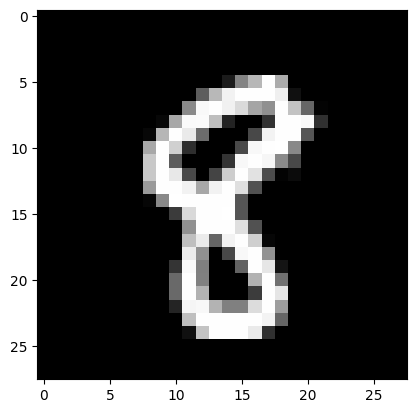

In [84]:
pyplot.imshow(x.reshape((28, 28)), cmap="gray")
pyplot.show()

In [88]:
probs = calculate_predictions(torch.tensor(x))
probs

tensor([1.1632e-05, 7.8863e-06, 1.4811e-04, 3.7708e-03, 4.1223e-05, 1.6870e-03,
        1.5630e-06, 1.4821e-06, 9.9334e-01, 9.8649e-04],
       grad_fn=<DivBackward0>)

El modelo le acertó esta vez, la probabildiad más alta es de que sea un 8:

In [90]:
torch.argmax(probs)

tensor(8)

#### Ejercicio Opcional:

Copiar esta notebook y borrar las celdas donde creamos la red neuronal (desde la sección "Creando nuestra red neuronal" en adelante). De modo que sólo quede la parte donde importamos el dataset. Y re-escribir:
- La creación de los pesos y la función que dado las features produce la predicción.
- La función de costo (negative log likehood).
- La métrica: accuracy.
- El loop de entrenamiento, incluyendo código para evaluar en cada época y mostrar cómo mejora la métrica.
- Un ejemplo de cómo se usa el modelo para inferencia (sobre un sólo caso, para calcular la predicción).

## Utilizando Pytorch


Pytorch define clases y funciones que proveen las abstracciones comunes a trabajar con redes neuronales.

Una abstracción es la de Dataset. Un Daataset es una lista de ejemplos, sobre el que se va a entrenar. Existen diferentes tipos de Dataset, TensorDataset es un tipo heredado de Dataset, que sirve para definir una lista dejemplo dado tensores de features y samples.

Uno puede crear sus propios tipos de datasets tal como se muetra en este [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Para nuestro fin, TensorDataset nos viene bien, ya que tenemos los samples en tensores (tanto las features como las targets).

In [109]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
valid_dataset = TensorDataset(torch.tensor(x_valid), torch.tensor(y_valid))

Un dataset se puede indexar y obtener un ejemplo que será una tupla de (features, target):

In [99]:
type(train_dataset[0]), len(train_dataset[0])

(tuple, 2)

In [106]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([784]), tensor(7))

Otra abstracción que nos provee pytorch es el de DataLoader, que nos define un generador de batches dado un Dataset:

In [191]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

Los DataLoaders no son indexables: no podemos obtener el batch i-ésimo. Sino que son generadores: permite iterar sobre los batches.

Además la clase DataLoader provee funcionalidad aparejada al concepto de mini-batch: por ejemplo shufflear (randomizar) el orden de los ejemplos una vez que se itere sobre todo el dataset.

In [192]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([32, 784]), torch.Size([32]))

Una de las abstracciones más poderosas que posee Pytorch es la de nn.Module, para definir modelos. Un modelo escencialmente es una función que contiene parámetros. 

Los modelos pueden estar compuestos de modelos más simples. Por ejemplo nuestro modelo contiene tres variables de tipo nn.Linear (la clase nn.Linear hereda de nn.Module).

Heredando de nn.Module estamos creando nuestro propia arquitectura.

In [193]:
from torch import nn

class MyArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_1 = nn.Linear(28*28, 512)
        self.linear_layer_2 = nn.Linear(512, 512)
        self.linear_layer_3 = nn.Linear(512, 10)

    def forward(self, x):
        l1 = self.linear_layer_1(x)
        h1 = nn.ReLU()(l1)
        l2 = self.linear_layer_2(h1)
        h2 = nn.ReLU()(l2)
        l3 = self.linear_layer_3(h2)
        probs = nn.LogSoftmax(dim=-1)(l3)
        return probs

Luego podemos crear un modelo instanciando la clase definida:

In [194]:
model = MyArchitecture()

Cuando llamemos al modelo en una entrada determinada, se ejecutará el código de la función forward para dicha entrada:

In [195]:
log_probs = model(train_dataset[0][0])
log_probs, log_probs.shape

(tensor([-2.3114, -2.2874, -2.3168, -2.3591, -2.3102, -2.3324, -2.2724, -2.2291,
         -2.3245, -2.2883], grad_fn=<LogSoftmaxBackward0>),
 torch.Size([10]))

Notar que el modelo es ligeramente distinto al implementado anteriormente: las predicciones no son probabilidades sino el log de las probabilidades. Esto es debido a que calcular el log del softmax es fácil debido a un trabajo algebraico (el softmax es un cociente y el log del cociente es la diferencia de logs). Y de todas formas le íbamos a aplicar log para la función de costo. 

In [196]:
torch.exp(log_probs)

tensor([0.0991, 0.1015, 0.0986, 0.0945, 0.0992, 0.0971, 0.1031, 0.1076, 0.0978,
        0.1014], grad_fn=<ExpBackward0>)

In [197]:
torch.exp(log_probs).sum()

tensor(1.0000, grad_fn=<SumBackward0>)

Gracias al broadcasting, podemos llamar al modelo en un mini-batch:

In [198]:
log_probs_batch = model(x_batch)
log_probs_batch.shape

torch.Size([32, 10])

nn.Module implementa muchas funcionalidades comunes a los modelos como por ejemplo mostrar las variables que lo componen (notar que no muestra como se combinan dichas variables):

In [199]:
model

MyArchitecture(
  (linear_layer_1): Linear(in_features=784, out_features=512, bias=True)
  (linear_layer_2): Linear(in_features=512, out_features=512, bias=True)
  (linear_layer_3): Linear(in_features=512, out_features=10, bias=True)
)

O también listas los parámetros (muy útil para actualizarlos, nosotros en nuestra implementación anterior tuvimos que crear manualmente una lista a la cual llamamos weights de todos los parámetros a actualizar):

In [200]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0039,  0.0006,  0.0080,  ...,  0.0202,  0.0259, -0.0136],
         [-0.0223, -0.0252, -0.0076,  ...,  0.0113,  0.0170,  0.0354],
         [-0.0064, -0.0170,  0.0080,  ..., -0.0148,  0.0064, -0.0043],
         ...,
         [ 0.0018,  0.0209,  0.0322,  ..., -0.0317,  0.0072, -0.0111],
         [ 0.0228,  0.0205, -0.0291,  ..., -0.0048,  0.0223, -0.0288],
         [-0.0158,  0.0215,  0.0341,  ...,  0.0225, -0.0036,  0.0082]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.5272e-03, -2.4023e-02,  6.0572e-03, -3.4850e-02, -1.5220e-03,
          4.3627e-03,  1.6719e-02,  3.2558e-02,  2.9371e-02,  1.4942e-02,
         -2.0186e-02,  1.7683e-02, -2.5695e-03, -3.5563e-02,  2.3919e-02,
          9.0389e-03, -3.0987e-02, -1.1462e-02, -1.0536e-02,  1.2851e-02,
         -3.2080e-02,  1.0557e-02, -2.5109e-02, -2.3409e-02, -2.9000e-02,
          2.7170e-03,  2.2378e-02,  6.2972e-04, -1.4320e-02, -1.9974e-02,
          1.0752e-02, -1.4607e-02,  1.13

Pytorch provee también funciones de costo, como NLL (Negative Log Likehood). NLLLoss() asume que recibe log probs.

In [201]:
loss_func = nn.NLLLoss()
loss = loss_func(log_probs_batch, y_batch)
loss

tensor(2.3053, grad_fn=<NllLossBackward0>)

Otra abstracción que provee Pytorch es la de optimizador. 
Un optimizador toma los pesos cuando es construido (también se dice que se registran los pesos en el optimizador) y oculta la forma en la que los pesos son actualizados teniendo en cuenta los gradientes: sólo basta tener los gradientes calculados dentro de los pesos (haber llamado a loss.backward()) y luego llamar al método .step(), que hará la actualización sobre los pesos registrados.

Existen cálculos de actualización de los pesos (que también hacen uso del gradiente del costo respecto a los mismos), que mejoran la convergencia. Usando un optimizador en vez de hacer la cuenta manualmente hace que podamos cambiar

Otra funcionalidad que provee el optimizador es setear en cero los gradientes de los parámetros registrados. Recordar que de no hacerlo se acumularán los gradientes entre llamadas sucesivas a backward.

In [202]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Seteamos los gradientes de los parámetros en cero
optimizer.zero_grad()
print(list(model.parameters())[0].grad)

# Calculamos las predicciones, el costo y los gradientes
probs_batch = model(x_batch)
loss_func = nn.NLLLoss()
loss = loss_func(log_probs_batch, y_batch)
loss.backward()
print(list(model.parameters())[2].grad)

# Hacemos un paso de optimización
optimizer.step()

None
tensor([[-2.7826e-04, -2.6213e-04, -1.3763e-04,  ...,  3.4854e-05,
          0.0000e+00, -3.5398e-04],
        [-2.6385e-04, -1.0901e-04,  6.0954e-04,  ...,  1.7323e-04,
          0.0000e+00, -3.8353e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.4630e-05,  6.9074e-04,  7.8683e-04,  ...,  3.7135e-04,
          0.0000e+00,  3.4842e-04],
        [-1.5813e-04,  1.5044e-04,  4.3805e-04,  ...,  2.0042e-04,
          0.0000e+00, -4.0906e-04],
        [ 1.7474e-05, -3.6681e-04, -2.9460e-04,  ..., -5.6863e-05,
          0.0000e+00, -4.2107e-06]])


In [203]:
loss_func(predictions, y_valid_batch)

tensor(0.2177, grad_fn=<NllLossBackward0>)

Ya estamos en condiciones de escribir nuestro training loop usando Pytorch:

In [204]:
n_epochs = 15

for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    n_batches_train = 0
    for x_train_batch, y_train_batch in train_dataloader:
        predictions = model(x_train_batch)
        loss = loss_func(predictions, y_train_batch)
        loss_train_sum += loss.item()
        n_batches_train += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    for x_valid_batch, y_valid_batch in valid_dataloader:
        predictions = model(x_valid_batch)
        loss = loss_func(predictions, y_valid_batch)
        loss_validation_sum += loss.item()
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation} | accuracy {accuracy_validation}')

epoch 0 | train loss 2.218994081972506 | validation loss 2.2654674997409034 | accuracy 0.6078274760383386
epoch 1 | train loss 2.0315826457148543 | validation loss 2.1427781314935275 | accuracy 0.7012779552715654
epoch 2 | train loss 1.6119085942594389 | validation loss 1.851045632164065 | accuracy 0.7386182108626198
epoch 3 | train loss 1.1142494590899434 | validation loss 1.3720462188763414 | accuracy 0.790535143769968
epoch 4 | train loss 0.8042411773730391 | validation loss 0.9746000539852272 | accuracy 0.8353634185303515
epoch 5 | train loss 0.6390524514186116 | validation loss 0.7510703354215896 | accuracy 0.8544329073482428
epoch 6 | train loss 0.5422922998381118 | validation loss 0.6264618161543775 | accuracy 0.8699081469648562
epoch 7 | train loss 0.48204053600375263 | validation loss 0.5502494796872215 | accuracy 0.8802915335463258
epoch 8 | train loss 0.4417598305133204 | validation loss 0.49969196352948003 | accuracy 0.8848841853035144
epoch 9 | train loss 0.412374724119235

La ventaja no es sólo que queda más corto, además está más "encapsulado": es más fácil de cambiar alguna de sus partes sin introducir cambios en otras partes.

#### Ejercicio opcional 2

Re-escribir el código de la unidad anterior utilizando el modelo resnet34 con pesos entrenados para ImageNet.

ResNet es una familia de arquitecturas de redes convolucionales.

In [210]:
import torchvision.models

resnet_model = torchvision.models.resnet34()
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

No es necesario para este ejercicio saber de redes convolucionales. Basta saber que resnet espera que le pasen un tensor de dimensiones $(3,H,W)$ siendo $3$ la cantidad de canales, $H$ la altura de una imágen y $W$ la anchura.

Para aplicarlo, debemos des-aplanar las 784 features que componene cada sample:

In [223]:
x_batch_new = x_batch.reshape(-1,28,28)
x_batch_new.shape

torch.Size([32, 28, 28])

Podemos crear un ResNet con 1 solo canal, pero como vamos a usar un ResNet con pesos ya entrenado en el dataset ImageNet (que es un dataset a color), crearemos 3 canales iguales:

In [230]:
x_batch_new = torch.stack([x_batch_new,x_batch_new,x_batch_new]).permute(1,0,2,3)
x_batch_new.shape

torch.Size([32, 3, 28, 28])

Corroboremos que de des-aplanó correctamente mostrando la primera imágen:

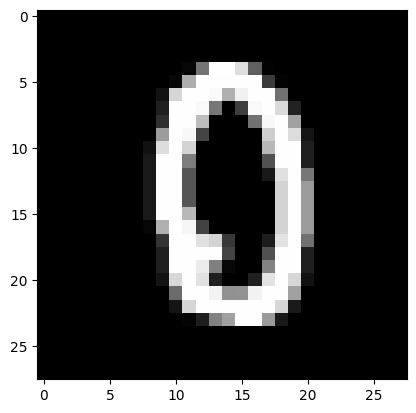

In [233]:
pyplot.imshow(x_batch_new[0,0], cmap="gray")
pyplot.show()

Finalmente podemos calcular la predicción del modelo:

In [239]:
logprobs = resnet_model(x_batch_new)
logprobs.shape, logprobs[0]

(torch.Size([32, 10]),
 tensor([ 1.8148,  1.0982, -0.2982,  1.5775, -1.2970,  0.8447,  0.2607,  1.7301,
         -0.2534, -0.3613], grad_fn=<SelectBackward0>))

Como resnet_model está entrenado en ImageNet, predice 1000 logprobs. Podemos cambiar la última capa lineal de resnet_model para adaptarlo a nuestro problema:

In [237]:
resnet_model.fc = nn.Linear(512, 10)

In [240]:
logprobs = resnet_model(x_batch_new)
logprobs.shape, logprobs[0]

(torch.Size([32, 10]),
 tensor([ 1.8148,  1.0982, -0.2982,  1.5775, -1.2970,  0.8447,  0.2607,  1.7301,
         -0.2534, -0.3613], grad_fn=<SelectBackward0>))

Esta última capa es completamente nueva. Los pesos son completamente aleatorios. Cuándo esto sucede lo recomendable es entrenar algunas épocas esta capa solamente y luego entrenar toda la red. Esto se puede lograr pasando al optimizer sólo los parámetros de ésta última capa. Y luego crear otro optimizer y pasarle todos los parámetros del modelo.

#### Ejercicio opcional 3

Crear un dataset de imágenes de tu interés y entrenar un clasificar ResNet (ver ejercicio anterior) en dicho dataset.

Para crear un dataset se puede utilizar, por ejemplo la API de Bing para descargar automáticamente imágenes